### Question 1 ( 10pts+5pts+10pts+5pts+10pts)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

1) We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

2) Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

3) When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 




In [1]:
import pandas as pd
import numpy as np
Data1=pd.read_csv("https://serv.cusp.nyu.edu/classes/ML_2016_Spring/ML_2017/PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0



### Your Python code should provide the following outputs:








In [2]:
import numpy as np
from matplotlib import pyplot as pl
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel
%matplotlib inline

In [3]:
len(Data1)

1115

In [4]:
X = Data1.iloc[:,:2]
Y = np.log(Data1.iloc[:,2]) - np.log(Data1.iloc[:,2]).mean()


**1) The kernel after parameter optimization and fitting to the observed data.**

**2) The log marginal likelihood of the training data.  **



In [5]:
kernel = 1* RBF(length_scale=100.0, length_scale_bounds=(1e-3, 1e3)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e10))
gp = GaussianProcessRegressor(kernel=kernel,
                              n_restarts_optimizer=10,random_state=1)
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, Y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=100) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=10, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=1)

In [6]:
print gp.log_marginal_likelihood_value_
print gp.kernel_

-1365.02775338
0.662**2 * RBF(length_scale=0.0355) + WhiteKernel(noise_level=0.567)


**3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values).**

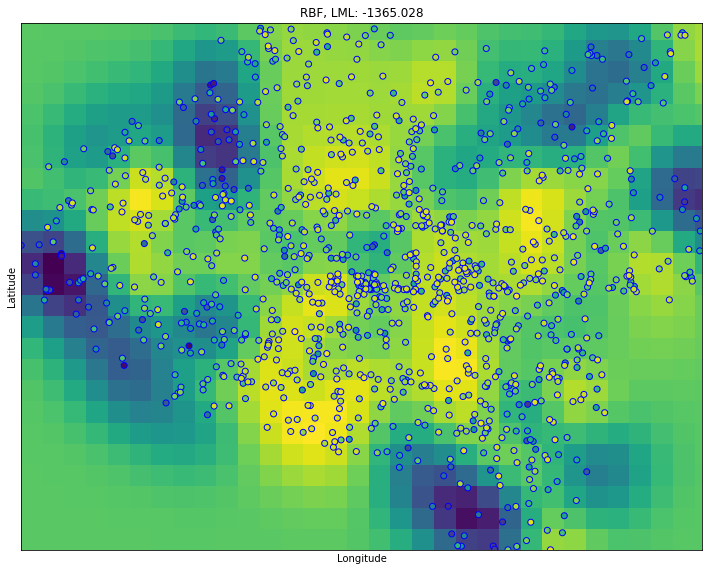

In [7]:
h = .02  # step size in the mesh
x_min, x_max = X.iloc[:, 0].min(), X.iloc[:, 0].max()
y_min, y_max = X.iloc[:, 1].min(), X.iloc[:, 1].max()

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

pl.figure(figsize=(10, 10))
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
pl.subplot(1, 1, 1)
Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1]))
pl.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

# Plot also the training points
pl.scatter(X.iloc[:, 0], X.iloc[:, 1], c = Y, edgecolors = 'b')
pl.xlabel('Longitude')
pl.ylabel('Latitude')
pl.xlim(xx.min(), xx.max())
pl.ylim(yy.min(), yy.max())
pl.xticks(())
pl.yticks(())
pl.title("%s, LML: %.3f" %
          ("RBF", gp.log_marginal_likelihood_value_))

pl.tight_layout()


**4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location?**

In [8]:
y_pred, y_std = gp.predict(X, return_std=True)

In [9]:
len(Y[(Y > y_pred + 2 * y_std) | (Y < y_pred - 2 * y_std)])

49

In [10]:
p = len(Y[(Y > y_pred + 2 * y_std) | (Y < y_pred - 2 * y_std)]) * 100.0/ len(Y) 
print('Percentage of sensors have average traffic counts more than two standard \
deviations higher or lower than the model predicts given their spatial location is %' + '%2f.'%p)

Percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location is %4.394619.


** 5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values.**




In [11]:
a = Data1[(Y > y_pred + 2 * y_std)]
b = Data1[(Y < y_pred - 2 * y_std)]
c = Data1[(Y > y_pred - 2 * y_std) & (Y < y_pred + 2 * y_std) ]

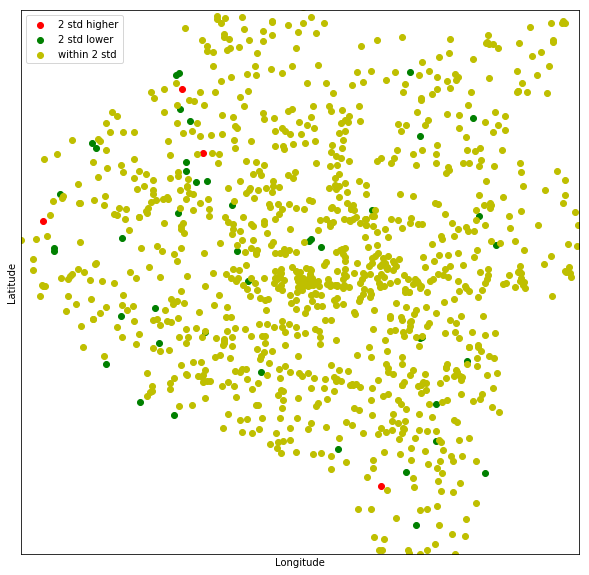

In [12]:
pl.figure(figsize=(10, 10))
pl.scatter(a.iloc[:, 0], a.iloc[:, 1], c = 'r', label = '2 std higher')
pl.scatter(b.iloc[:, 0], b.iloc[:, 1], c = 'g', label = '2 std lower')
pl.scatter(c.iloc[:, 0], c.iloc[:, 1], c = 'y', label = 'within 2 std')
pl.xlabel('Longitude')
pl.ylabel('Latitude')
pl.xlim(xx.min(), xx.max())
pl.ylim(yy.min(), yy.max())
pl.xticks(())
pl.yticks(())
pl.legend()


### Question 2: Cluster-based anomaly detection (10pts, 2.5pts+2.5pts+2.5pts+2.5pts)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)








(1, 0)		Anomaly / Not Anomaly

** Anomaly** : Since this point is 10 standard deviation away from the center, so it is anomaly point.

(35, 5)		Anomaly / Not Anomaly

**Not Anomaly** : This point is right on the center.


(15, 19)	Anomaly / Not Anomaly

**Not Anomaly** : It is 1 standard deviation away, but the cluster size is very small to detect anomaly.

(10, 11)	Anomaly / Not Anomaly

**Not Anomaly** : It is 1 satndard deviation away from the center, is not really likely to be anomaly. 

### Question 3: Anomaly detection (5pts+10pts+10pts+10pts+10pts+5pts)

For this question, use the "County Health Indicators dataset" provided to identify the most anomalous counties. Please list the top 5 most anomalous counties by following models: 




In [32]:
import pandas as pd
import numpy as np

In [3]:
Data3=pd.read_csv("https://serv.cusp.nyu.edu/classes/ML_2016_Spring/ML_2017/2016CountyHealthIndicators.csv")
Data3.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12.0,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59


In [10]:
Data3.shape

(3141, 31)

Data preprocessing hints: a. convert the strings to float(except the first column). b. drop all nan's. 



In [96]:
Data3.replace('?',np.nan, inplace = True)
Data3.iloc[:,1:] = Data3.iloc[:,1:].apply(lambda x: x.astype(float),axis=1)
Data3.dropna(how = 'any', inplace = True)
Data3.reset_index(drop=True, inplace=True)
Data3.shape

(2486, 31)

**(1) Pick up features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"] and use pd.cut() to categorize each feature into 5 categories: 0,1,2,3,4. **

a. Use HillClimbSearch and BicScore to learn the baysian network structure. 

b. Which 5 counties have lowest logliklihood values? Please show the counties' name with its loglikelihood values. 





In [97]:
# convert to categorical
x = Data3[["'\% Smokers'","'\% Obese'","'Violent Crime Rate'",\
               "'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"]]
xx=[]
for i in range(6):
    a=pd.cut(np.asarray(x)[:,i],5,labels=[0,1,2,3,4])
    xx.append(a)
x3=np.asarray(xx).T
x3.shape

(2486, 6)

In [98]:
data3=pd.concat((Data3.County,pd.DataFrame(x3)),axis=1)
data3.columns=["County","T1","T2","T3","T4","T5","T6"]
data3.head()

,County,T1,T2,T3,T4,T5,T6
0,"Autauga, Alabama",1,2,0,1,1,3
1,"Baldwin, Alabama",1,2,0,1,1,3
2,"Barbour, Alabama",2,4,0,2,3,3
3,"Bibb, Alabama",2,4,0,1,2,3
4,"Blount, Alabama",1,2,0,1,2,3


In [99]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BdeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator

data=data3.iloc[:,1:]
hc = HillClimbSearch(data, scoring_method=BicScore(data))
best_model = hc.estimate()
print(best_model.edges())
model = BayesianModel(best_model.edges())

# Learing CPDs using Maximum Likelihood Estimators
model.fit(data, estimator=MaximumLikelihoodEstimator)

[('T4', 'T5'), ('T5', 'T3'), ('T5', 'T1'), ('T1', 'T6'), ('T1', 'T2')]


In [100]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)
def logLiklihood(x,infer):
    a=x.T1
    b=x.T2
    c=x.T3
    d=x.T4
    e=x.T5
    f=x.T6
    return np.log((infer.query(['T1'], evidence={'T5': e}) ['T1']).values[a])+np.log(
    (infer.query(['T2'], evidence={'T1': a}) ['T2']).values[b])+np.log(
    (infer.query(['T3'], evidence={'T5': e}) ['T3']).values[c])+np.log(
    (infer.query(['T4']) ['T4']).values[d])+np.log(    
    (infer.query(['T5'], evidence={'T4': d}) ['T5']).values[e])+np.log(
    (infer.query(['T6'], evidence={'T1': a}) ['T6']).values[f])

In [101]:
data3.dropna(how = 'any', inplace = True)
data3.iloc[:,1:] = data3.iloc[:,1:].apply(lambda x: x.astype(int),axis=1)

In [102]:
logLiklihood(data3.iloc[0,1:],infer)

-2.9615278669004046

In [103]:
exmp=data3.iloc[:,:].apply(lambda x: logLiklihood(x,infer),axis=1)

In [104]:
exmp.sort_values()[:5]

1444   -16.608495
182    -14.827149
1577   -14.686742
1007   -14.457849
248    -13.671439
dtype: float64

In [115]:
Data3.iloc[[1444,182,1577,1007,248],:]

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
1444,"New York, New York",14.0,3.5,3.5,9.0,13.0,15.0,7.8,18.0,98.0,...,24.0,8.7,41.0,13.0,620.0,32.0,10.8,25.0,6.0,63.0
182,"San Francisco, California",11.0,3.2,3.1,7.0,12.0,15.0,7.3,14.0,100.0,...,14.0,6.9,28.0,8.8,703.0,55.0,8.0,27.0,36.0,46.0
1577,"Rolette, North Dakota",29.0,5.1,4.5,10.0,38.0,41.0,6.9,34.0,21.0,...,41.0,7.7,59.0,6.2,29.0,104.0,9.6,21.0,84.0,14.0
1007,"Suffolk, Massachusetts",16.0,3.5,3.8,9.0,15.0,21.0,7.6,20.0,100.0,...,32.0,7.6,52.0,10.1,910.0,46.0,10.4,26.0,41.0,46.0
248,"District of Columbia, District of Columbia",13.0,2.8,3.2,10.0,16.0,22.0,8.0,17.0,100.0,...,29.0,7.0,57.0,28.9,1259.0,58.0,12.7,22.0,34.0,44.0


**(2) Cluster based anomaly detection.**

a.Cluster with k-means. Please set k= 3.Compute each record's distance to the nearest cluster center and report the five counties which have top five highest distances.



In [106]:
X = Data3.iloc[:,1:]
y = Data3.iloc[:,:1]

In [107]:
from sklearn.cluster import KMeans
n=3
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)
res=pd.DataFrame(KM.transform(X))
res=pd.concat((Data3.County,res.min(1)),axis=1)
res.columns=["County","score"]
print res.sort_values("score",ascending=False)[:5]

                         County        score
1890      Shannon, South Dakota  1970.018443
1294   St. Louis City, Missouri  1332.735955
96         Crittenden, Arkansas  1208.900834
2304  Petersburg City, Virginia  1017.910163
995    Baltimore City, Maryland   918.374430


**b. Cluster with Gaussian Mixture. Please repeat (2)a but use loglikelihood for each record.**





In [111]:
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=5,random_state=999)
GM.fit(Data3.iloc[:,1:])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=999, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [112]:
pd.DataFrame(GM.score_samples(X)).sort_values(0)[:5]

,0
1890,-165.208741
1417,-162.836570
1577,-134.374146
248,-132.904180
66,-132.617130


In [113]:
Data3.iloc[[1890,1417,1577,248,66],:]

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
1890,"Shannon, South Dakota",33.0,5.9,4.7,7.0,41.0,45.0,1.6,24.0,2.0,...,54.0,6.5,68.0,2.8,0.0,200.0,11.8,44.0,64.0,22.0
1417,"Bronx, New York",29.0,5.0,4.3,10.0,19.0,29.0,7.0,29.0,99.0,...,43.0,6.4,63.0,2.6,620.0,38.0,10.8,38.0,23.0,50.0
1577,"Rolette, North Dakota",29.0,5.1,4.5,10.0,38.0,41.0,6.9,34.0,21.0,...,41.0,7.7,59.0,6.2,29.0,104.0,9.6,21.0,84.0,14.0
248,"District of Columbia, District of Columbia",13.0,2.8,3.2,10.0,16.0,22.0,8.0,17.0,100.0,...,29.0,7.0,57.0,28.9,1259.0,58.0,12.7,22.0,34.0,44.0
66,"Apache, Arizona",30.0,5.7,5.3,7.0,26.0,33.0,0.5,22.0,22.0,...,40.0,6.3,52.0,3.5,94.0,173.0,9.8,36.0,75.0,42.0


(3) Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you choose. 



In [130]:
#Isolation Forest
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X)



IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples=100, n_estimators=100, n_jobs=1,
        random_state=<mtrand.RandomState object at 0x1069c1780>, verbose=0)

In [161]:
score = pd.concat((Data3.County,pd.DataFrame(clf.decision_function(X))),axis=1)
score.columns=["County","score"]
score.sort('score',inplace=True)
score[:5]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,County,score
1890,"Shannon, South Dakota",-0.151165
1164,"Coahoma, Mississippi",-0.103224
1577,"Rolette, North Dakota",-0.096641
66,"Apache, Arizona",-0.087290
23,"Dallas, Alabama",-0.086162


(4) Compare and contrast the results from different models, and provide some intuitions on why each county was found to be anomalous.  





In [167]:
Abn = Data3.iloc[[1890,1577,66,248],:]
Abn

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
1890,"Shannon, South Dakota",33.0,5.9,4.7,7.0,41.0,45.0,1.6,24.0,2.0,...,54.0,6.5,68.0,2.8,0.0,200.0,11.8,44.0,64.0,22.0
1577,"Rolette, North Dakota",29.0,5.1,4.5,10.0,38.0,41.0,6.9,34.0,21.0,...,41.0,7.7,59.0,6.2,29.0,104.0,9.6,21.0,84.0,14.0
66,"Apache, Arizona",30.0,5.7,5.3,7.0,26.0,33.0,0.5,22.0,22.0,...,40.0,6.3,52.0,3.5,94.0,173.0,9.8,36.0,75.0,42.0
248,"District of Columbia, District of Columbia",13.0,2.8,3.2,10.0,16.0,22.0,8.0,17.0,100.0,...,29.0,7.0,57.0,28.9,1259.0,58.0,12.7,22.0,34.0,44.0


** Those counties shown above show up in two or more approaches that I use to detect abnomaly.**

In [172]:
Abn.iloc[:,1:] - X.mean()

,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
1890,15.796058,2.034191,0.946903,-1.222446,22.430008,13.977072,-5.493242,-3.162108,-61.002011,-0.604988,...,30.15527,1.954867,34.654063,-9.931175,-267.538616,125.545455,0.079928,29.041432,-16.197908,-8.881738
1577,11.796058,1.234191,0.746903,1.777554,19.430008,9.977072,-0.193242,6.837892,-42.002011,3.395012,...,17.15527,3.154867,25.654063,-6.531175,-238.538616,29.545455,-2.120072,6.041432,3.802092,-16.881738
66,12.796058,1.834191,1.546903,-1.222446,7.430008,1.977072,-6.593242,-5.162108,-41.002011,-1.604988,...,16.15527,1.754867,18.654063,-9.231175,-173.538616,98.545455,-1.920072,21.041432,-5.197908,11.118262
248,-4.203942,-1.065809,-0.553097,1.777554,-2.569992,-9.022928,0.906758,-10.162108,36.997989,8.395012,...,5.15527,2.454867,23.654063,16.168825,991.461384,-16.454545,0.979928,7.041432,-46.197908,13.118262


** And from the chart above we can see that most of these counties tend to have a higher percentage of poor health, smokers, Children in poverty, Single parent hoseholds, injury death rate and severe housing problems. At the same time, they have lower assciation rate, violent crime rate, and access to exercise percentage. **